# f-scLVM

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories

In [3]:
import sys
import os
import scipy as SP
sys.path.insert(0,'/Users/flo/projects/Auto_Bionf/scLVM2/py')
import cPickle as pickle
from fscLVMl.utils import *
import fscLVMl.core as fscLVM
import h5py
%load_ext rpy2.ipython
%pylab inline

#specify where the hdf5 file is
data_dir = '../../../data/'
out_base = './../results/'



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations. We provide an R script (in the R folder) which can be used to generate this input from a gene expression matrix, using annotation from REACTOME, MSigDB and Wikipathways. 

Usage is also illustrated in the next R cell; it can be skipped and provided hdf file can be used instead.





# Generating an input file using R 

In [3]:
%%R -i data_dir
#This illustrates the generation of input files using R; alternatatively a hdf5 fie containing the necessary daat is provided. 

library(rhdf5)
library(gplots)
require(GSEABase)
require(limma)
source('../../../R/Rutils.R')
#contains normalised read counts with gene IDs, variable genes and cell cycle stage as in Buettner et al
dataCounts = h5dump(paste0(data_dir,'normCountsBuettnerEtAl.h5f'))
geneIds
#log transformed and normalized expression matirx
Y = dataCounts$LogNcounts
print(dim(Y))
#variable genes
idx_het = which(dataCounts$genes_heterogen==1)
#cell cycle stage
labels = dataCounts$labels

#we consider variable genes only
countsMmusFilter= Y[idx_het,]
rownames(countsMmusFilter) = dataCounts$sym_names_het

#we also write out the cell cycle phase information that can be used either as covariate in the model or for plottting
modelMat = model.matrix(~as.factor(labels))[,2:3]
Known = cbind(modelMat)
colnames(Known) = paste("ccPhase",c("S", "G2M"),sep="")


#if you have custom gene sets add them here
#setsAdd = list()
#setsAdd[[1]]=custom_genes
#setsAdd_names = 'XXX'

write_scLVM2(countsMmusFilter, '_Buettneretal.hdf5', Known=Known, data_dir=data_dir)

/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: 
Attache Paket: ‘gplots’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Das folgende Objekt ist maskiert ‘package:stats’:

    lowess


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Lade nötiges Paket: GSEABase

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-10.10-x86_64.egg/rpy2/robjects/functions.py:106: UserWarning: Lade nötiges Paket: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/site-packages/rpy2-2.8.0.dev0-py2.7-macosx-1

[1] 38293   182


# Loading data

Arguments specify some options, incuding number of hidden factors (`nHidden`), minimum number of genes in a pathway (`minGenes`), whether to use the fast option (`doFast`), noise model (`noise`) and the data directory (`data_dir`). @Oli: could also omit the options here and use the defaults (not explicitly)

In [10]:
reload(fscLVM)
dFile = '_Buettneretal.hdf5'

data = load_hdf5(dFile, data_dir=data_dir)

FA = initFA(data['Y'], data['terms'],data['IMSigDB'],noise='gauss', nHidden=3, 
                   doFast=True, minGenes=15)
#iterate
FA.iterate(nIterations=2000)


iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
Converged after 701 iterations


Next, we initialise the model and iterate.



We then plot results. First, we show the relevance of the terms; then we plot the 2 most important factors, in this case G2M Checkpoint and P53 Pathway. 

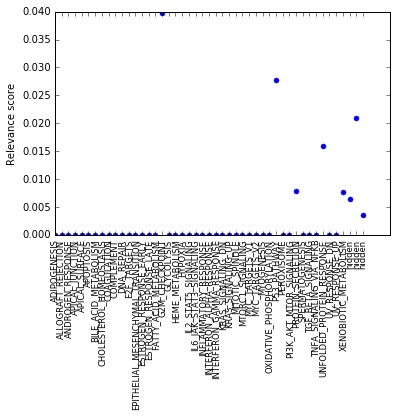

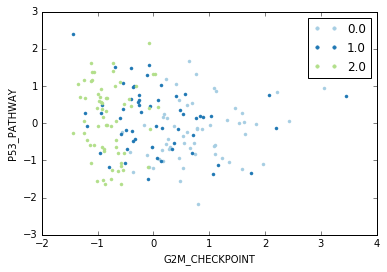

In [16]:
#scatter plot of two most important factors
#TODO integrate ploy's plot script.
plotTerms(FA, terms=FA.terms, madFilter=0.4)

dataFile = h5py.File(os.path.join(data_dir, dFile), 'r')
plotFactors(0,1,FA,lab = data['Known'][0,:]+2*data['Known'][1,:], 
                  terms=FA.terms, isCont=False, madFilter=0.4)



In [100]:
#specify out_file
FA.out_name = 'FA_Buettner_MSigDB'
saveFA(FA)

In [22]:
utils.saveFA(FA, Ycorr=Ycorr, Ycorr_lat=Ycorr3)

./../../core/utils.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if Ycorr != None:
./../../core/utils.py:48: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if Ycorr_lat != None:


u'/Users/flo/projects/Auto_Bionf/scLVM2/py/demo/ipynb'